### Author: Kyle Tranfaglia ###
### Course: DSCI 470 ###
### Assignment: The Project ###
### Last Updated: 10/16/24 ###

## Background: ##

## Question: Do larger rating differences lead to more predictable game outcomes (e.g., the higher-rated player winning more often)? How do opening choices differ between players with higher Elo ratings vs. lower-rated players? Are higher Elo-rated players more likely to play in certain event types? Which features (event type, ECO code, result, etc.) have the most predictive power for Elo and how can we use the results to construct match-making criteria? How does the Elo difference between players impact the predictability of the match result? Are certain openings more likely to be played in a certain event or by a certain Elo range? ##

## Prepare for Analysis: Import Libraries and Read in Data

In [1]:
# Import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Read in data set and strip beginning spaces from the 'Event' column
df_chess = pd.read_csv("Data/Big_chess_data.csv", nrows=1000000, converters= {'Event': lambda x: x.strip() if isinstance(x, str) else x})


## Utility Functions ##

In [8]:
# Set up the plotting style
sns.set_theme(style='whitegrid')


# Function to plot bar charts
def plot_frequencies(counts, title, xlabel, ylabel):
    top_n = 50
    counts = counts.nlargest(top_n)

    plt.figure(figsize=(12, 8))
    sns.barplot(x=counts.index, y=counts.values, hue=counts.index, legend=False, palette='viridis')
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.yscale('log')
    plt.xticks(rotation=90)  # Rotate x labels for better readability
    plt.show()


# Extract the first word of a column entry
def extract_first_word(entry):
    return entry.split()[0]


# Extract the first two words of a column entry
def extract_first_two_words(entry):
    words = entry.replace(":", "").split()  # Remove colons and split the string
    return ' '.join(words[:2]) if len(words) > 1 else words[0]

## Explore the Data ##

             WhiteElo        BlackElo  WhiteRatingDiff  BlackRatingDiff
count  1000000.000000  1000000.000000    999186.000000    999186.000000
mean      1744.800411     1743.103784         0.678818        -0.268921
std        264.101504      265.623353        22.867394        21.872902
min        782.000000      728.000000      -555.000000      -570.000000
25%       1563.000000     1560.000000        -9.000000       -10.000000
50%       1744.000000     1742.000000         1.000000        -1.000000
75%       1922.000000     1922.000000        10.000000         9.000000
max       3006.000000     3069.000000       669.000000       644.000000

               Event            White       Black Result     UTCDate   UTCTime  \
0         Classical          eisaaaa    HAMID449    1-0  2016.06.30  22:00:01   
1             Blitz           go4jas  Sergei1973    0-1  2016.06.30  22:00:01   
2  Blitz tournament  Evangelistaizac      kafune    1-0  2016.06.30  22:00:02   
3    Correspondence       

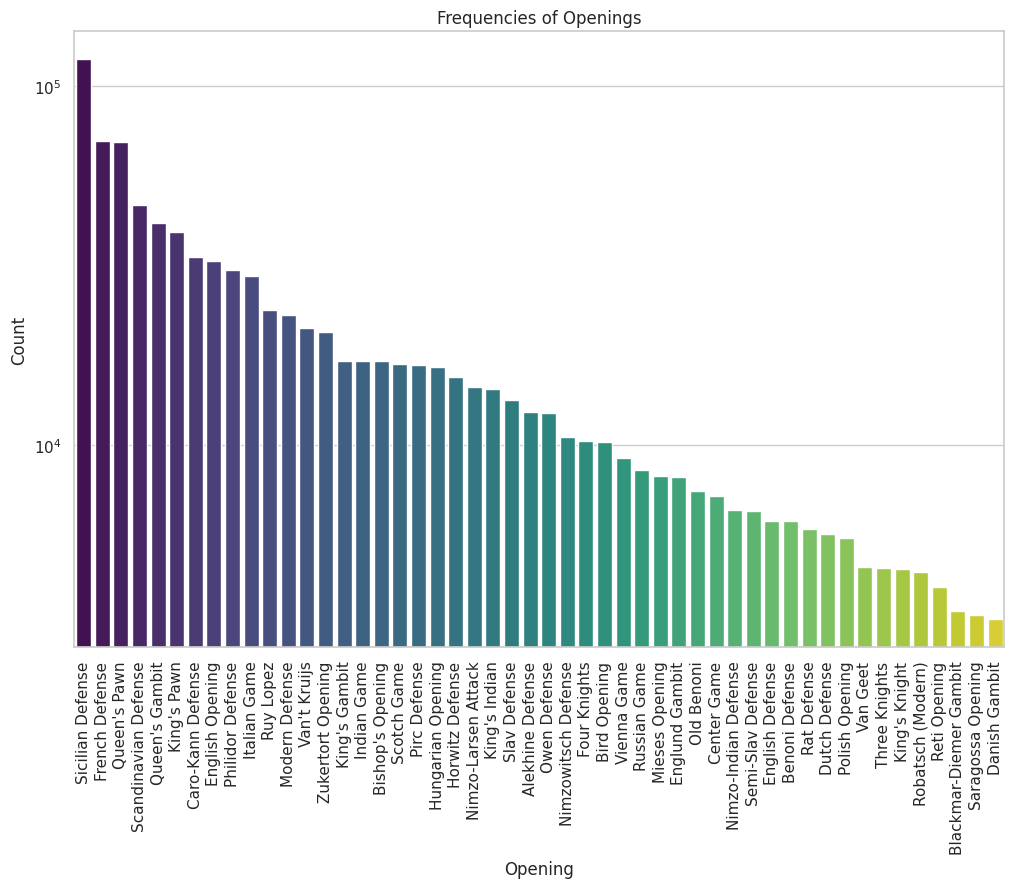


Frequency of ECO
A00    66841
A01    14494
A02     5645
A03     4615
A04    17372
       ...  
E94      244
E95       13
E97      169
E98       69
E99       40
Name: count, Length: 488, dtype: int64


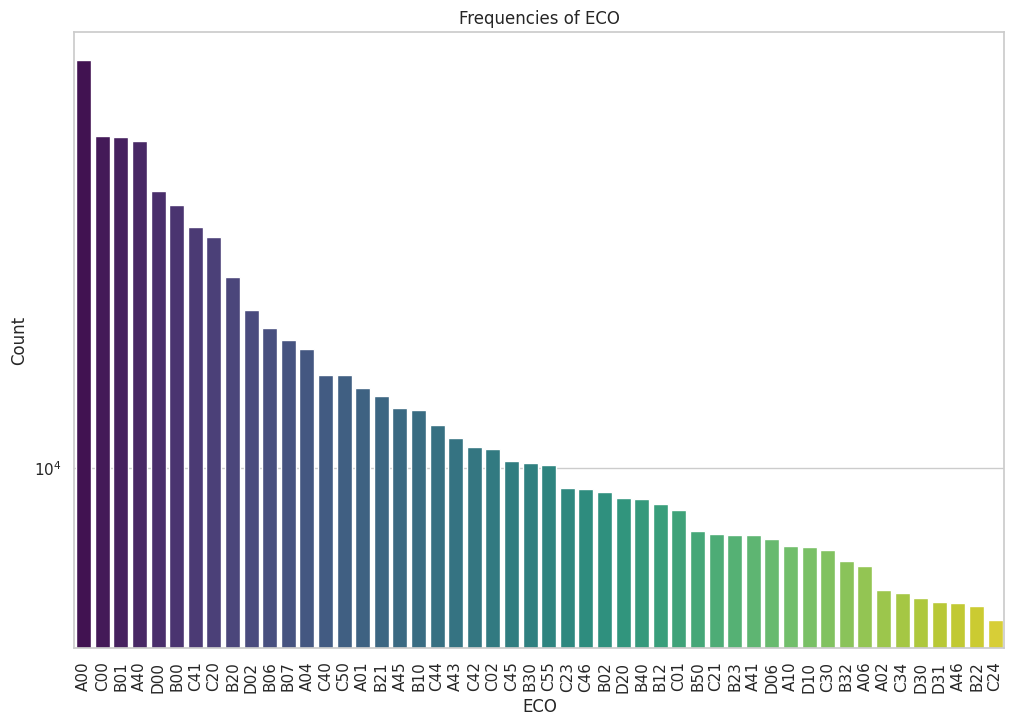


Frequency of TimeControl
-         3818
0+1       6319
0+10       139
0+11        16
0+12        53
          ... 
960+5       38
960+7       16
960+8      106
960+9        4
960+90       3
Name: count, Length: 583, dtype: int64


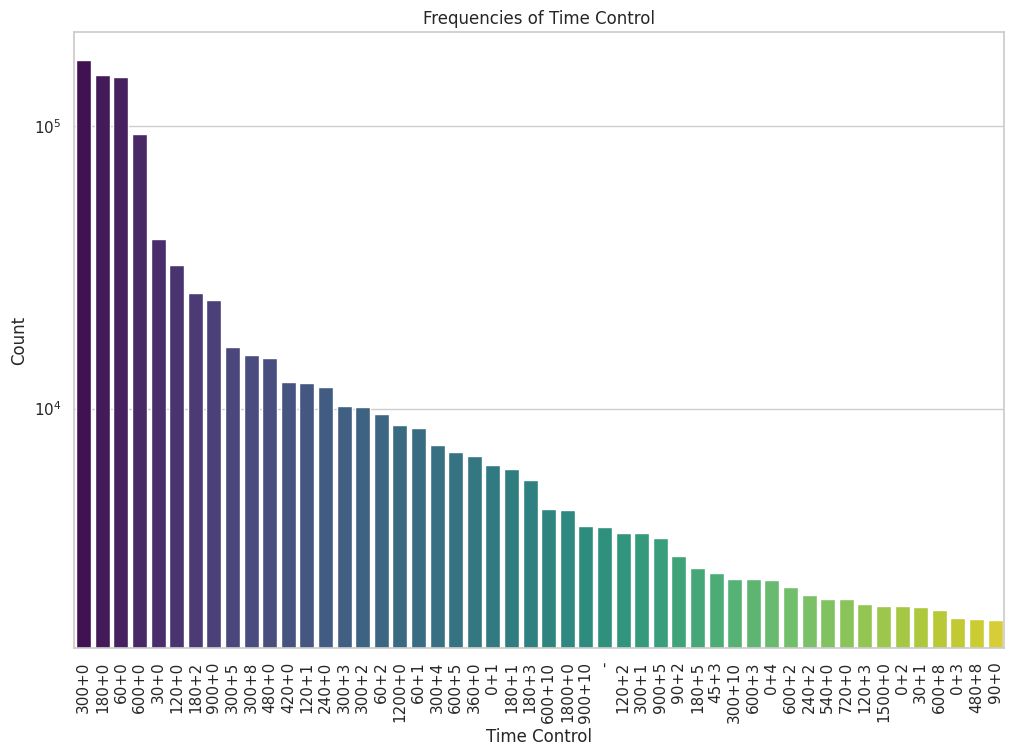


Frequency of Event
Blitz                   374775
Blitz tournament         75786
Bullet                  196239
Bullet tournament        80541
Classical               241423
Classical tournament     27418
Correspondence            3818
Name: count, dtype: int64


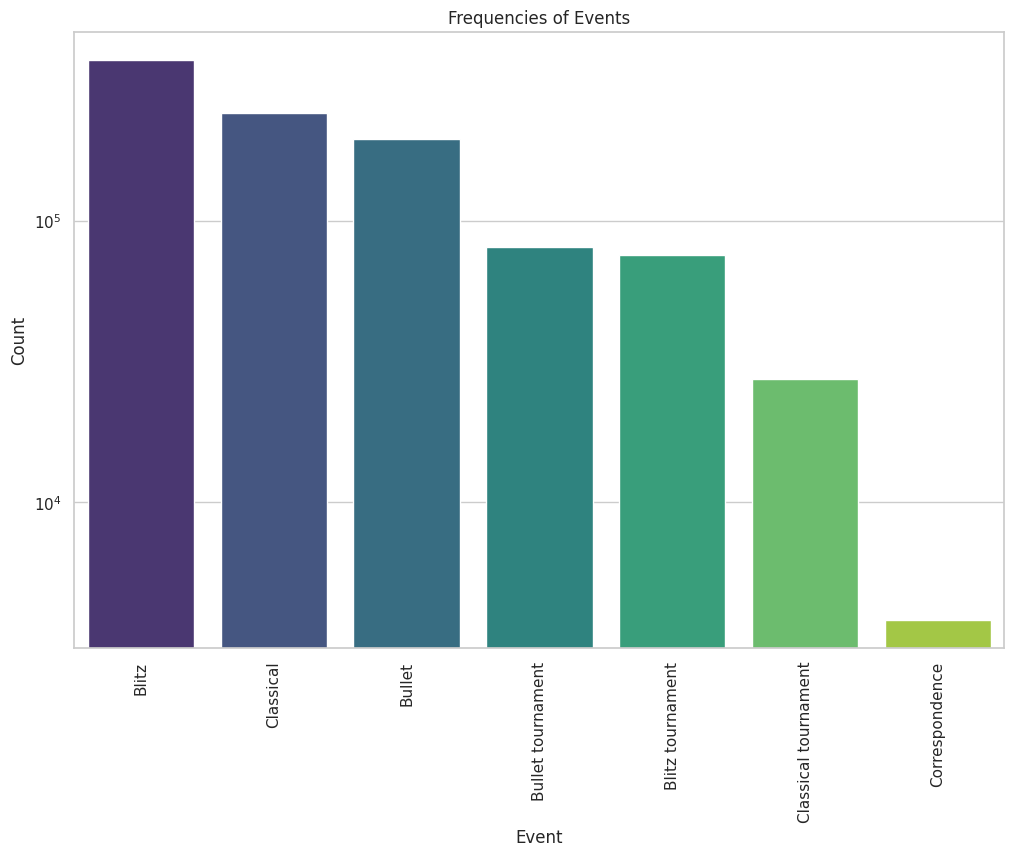


Frequency of Termination
Abandoned             2367
Normal              678954
Rules infraction        22
Time forfeit        318657
Name: count, dtype: int64


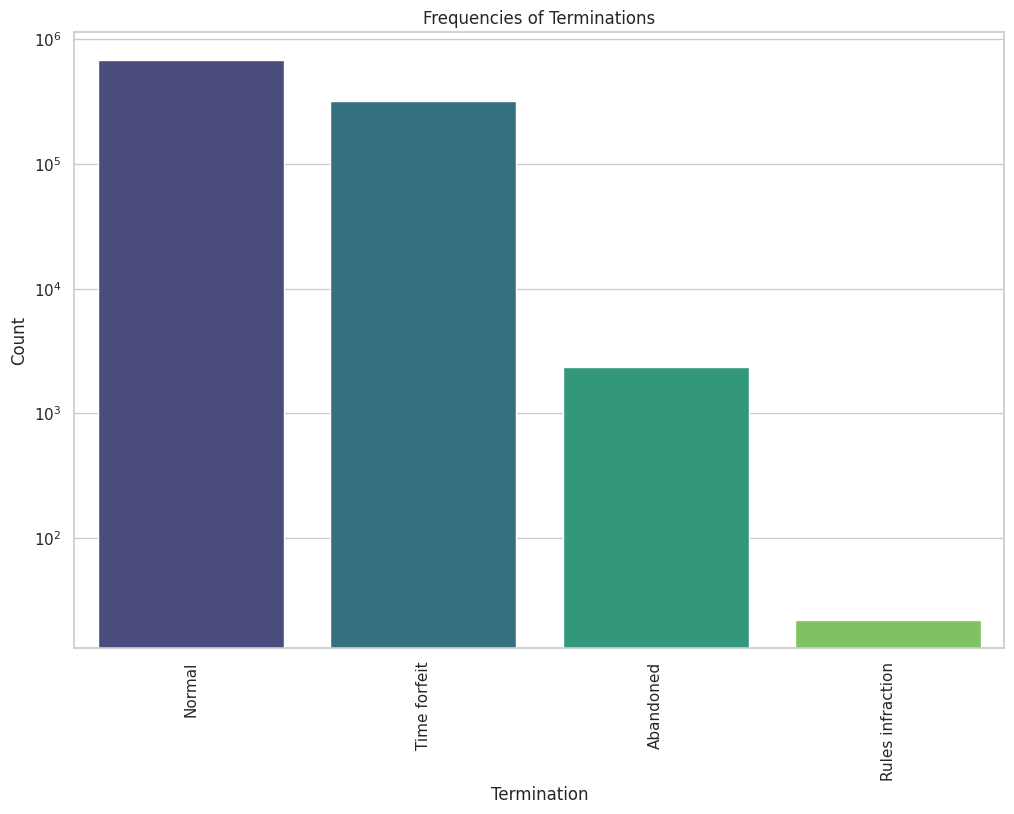

In [11]:
# Display some data, statistics, and summary info
print(df_chess.describe())
print("\n", df_chess.head())

# Create a new column with generalized openings (group all opening variations)
df_chess['generalized_Opening'] = df_chess['Opening'].apply(extract_first_two_words)

# Get and display data fequencies for some features
opening_counts = df_chess['generalized_Opening'].value_counts().sort_index()
print("\nFrequency of", opening_counts)
plot_frequencies(opening_counts, 'Frequencies of Openings', 'Opening', 'Count')

ECO_counts = df_chess['ECO'].value_counts().sort_index()
print("\nFrequency of", ECO_counts)
plot_frequencies(ECO_counts, 'Frequencies of ECO', 'ECO', 'Count')

time_control_counts = df_chess['TimeControl'].value_counts().sort_index()
print("\nFrequency of", time_control_counts)
plot_frequencies(time_control_counts, 'Frequencies of Time Control', 'Time Control', 'Count')

event_counts = df_chess['Event'].value_counts().sort_index()
print("\nFrequency of", event_counts)
plot_frequencies(event_counts, 'Frequencies of Events', 'Event', 'Count')

termination_counts = df_chess['Termination'].value_counts().sort_index()
print("\nFrequency of", termination_counts)
plot_frequencies(termination_counts, 'Frequencies of Terminations', 'Termination', 'Count')


